This notebook explores: 
* The relative usage of each tool  
* The overall accuracy of each tool
* The bias of each tool towards yes/no answers 
* The relationship between confidence and accuracy for each tool
* The diversity of tools and prompts used for different questions

### imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.precision", 2)
pd.set_option('display.max_columns', None)

plt.style.use('ggplot')

### Functions

In [2]:
def accuracy(data):
    correct_answers_mask = data["currentAnswer"] == data["vote"]
    n_answers = correct_answers_mask.count()
    n_answers_success = correct_answers_mask.sum()

    if n_answers == 0:
        accuracy = None
    elif n_answers_success == 0:
        accuracy = 0
    else:
        accuracy = n_answers_success/n_answers * 100

    return pd.Series({"n_correct": n_answers_success, "n_pred": n_answers, "accuracy": accuracy})


def acc_per_tool(group, col: str, conf: float):
    return group.apply(lambda x: accuracy(x[x[col] == conf]))


def gen_stats(df, group, col: str):
    stats = {f"{col}_{prob}" : acc_per_tool(group, col, prob) for prob in sorted(df[col].unique())}
    stats["total"] = group.apply(accuracy)
    return pd.concat(stats.values(), axis=1, keys=stats.keys())

### load data

In [3]:
dataset = pd.read_csv("./data/dataset.csv")
print(f"Full dataset shape: {dataset.shape}")

# only error == False
dataset = dataset[dataset["error"] == False]
print(f"Dataset shape without errors: {dataset.shape}")

str_cols = ("id", "currentAnswer", "title", "request_id", "prompt_request", "prompt_response", "tool", "nonce", "vote")
for col in str_cols:
    dataset[col] = dataset[col].astype("string")
dataset.head()

Full dataset shape: (82691, 18)
Dataset shape without errors: (69776, 18)


,id,currentAnswer,title,request_id,request_block,prompt_request,tool,nonce,deliver_block,error,error_message,prompt_response,p_yes,p_no,confidence,info_utility,vote,win_probability
0,0x0094fa304017d5c2b355790e2976f769ea600492,No,Will the Hisense U8K be considered a top-tier ...,2315482717523248142566209479998403158981026548...,29555552,"With the given question ""Will the Hisense U8K ...",prediction-online,2a54469c-a055-4c9c-a558-51262cd4a787,29557480,False,NaN,<NA>,0.50,0.50,0.8,0.6,<NA>,0.50
1,0x0094fa304017d5c2b355790e2976f769ea600492,No,Will the Hisense U8K be considered a top-tier ...,3469031602277041443388090267865736162834108248...,29555700,"With the given question ""Will the Hisense U8K ...",prediction-online,01538074-5f78-4e28-8058-47b6d94b682f,29557255,False,NaN,<NA>,0.60,0.40,0.8,0.6,Yes,0.60
2,0x0094fa304017d5c2b355790e2976f769ea600492,No,Will the Hisense U8K be considered a top-tier ...,9159320707509526863870444110528895654334237837...,29555970,"Given the information available, and consideri...",prediction-online,099e342e-a41e-4689-be76-3570d8a256cf,29556974,False,NaN,<NA>,0.65,0.35,0.8,0.6,Yes,0.65
3,0x0094fa304017d5c2b355790e2976f769ea600492,No,Will the Hisense U8K be considered a top-tier ...,1023057355467695172592840970123356496552194251...,29556083,"With the given question ""Will the Hisense U8K ...",prediction-online,438e9446-0f55-4e5e-b879-c06e93520969,29556905,False,NaN,<NA>,0.60,0.40,0.8,0.7,Yes,0.60
5,0x0094fa304017d5c2b355790e2976f769ea600492,No,Will the Hisense U8K be considered a top-tier ...,1049080869663393036021703581760667415975346534...,29556451,"With the given question ""Will the Hisense U8K ...",prediction-online,7209cbcf-030e-4664-956f-a1882c3d35c2,29556491,False,NaN,<NA>,0.60,0.40,0.8,0.5,Yes,0.60


In [4]:
dataset.columns

Index(['id', 'currentAnswer', 'title', 'request_id', 'request_block',
       'prompt_request', 'tool', 'nonce', 'deliver_block', 'error',
       'error_message', 'prompt_response', 'p_yes', 'p_no', 'confidence',
       'info_utility', 'vote', 'win_probability'],
      dtype='object')

```
id - bet id
currentAnswer - current winning answer (??)
title - the question
request_id - request for processing by Mech
request_block - the block in which the job was requested
prompt - prompt given by the Trader
tool - tool requested by the trader
nonce - nonce
deliver_block - block in which the result was delivered back to the trader
p_yes - probability of yes by the tool
p_no - probability of no by the tool
confidence - confidence by the tool
info_utility - utility of the additional info given to the LLM (??)
vote - the traders position
win_probability - win probability as predicted by the tool (same as p_yes or p_no)
```

- is actual winning answer captured?

In [5]:
dataset.shape

(69776, 18)

In [6]:
dataset.describe()

,request_block,deliver_block,p_yes,p_no,confidence,info_utility,win_probability
count,6.98e+04,6.98e+04,69776.00,69776.00,69776.00,69776.00,69776.00
mean,3.07e+07,3.07e+07,0.48,0.52,0.78,0.56,0.67
std,6.76e+05,6.75e+05,0.20,0.20,0.08,0.19,0.10
min,2.89e+07,2.89e+07,0.00,0.00,0.00,0.00,0.50
25%,3.01e+07,3.01e+07,0.30,0.40,0.80,0.50,0.60
50%,3.06e+07,3.06e+07,0.60,0.40,0.80,0.60,0.70
75%,3.12e+07,3.12e+07,0.60,0.70,0.80,0.60,0.75
max,3.20e+07,3.20e+07,1.00,1.00,1.00,1.00,1.00


### Normalize confidence

In [7]:
dataset["confidence"].unique()

array([0.8 , 0.9 , 0.7 , 0.6 , 0.5 , 0.1 , 0.75, 0.85, 0.3 , 1.  , 0.35,
       0.2 , 0.4 , 0.65, 0.99, 0.95, 0.55, 0.  , 0.62, 0.88, 0.64, 0.81,
       0.68])

In [8]:
# number of votes below 0.5
print(f"Number of votes below 0.5: {dataset[dataset['confidence'] < 0.5].shape[0]}")

# drop votes below 0.5
dataset = dataset[dataset["confidence"] >= 0.5]

Number of votes below 0.5: 39


In [9]:
# bucket confidence into 0.5, 0.6, 0.7, 0.8, 0.9
dataset['confidence'] = dataset['confidence'].apply(lambda x: round(x, 1))

# if confidence is 1 --> 0.9
dataset['confidence'] = dataset['confidence'].apply(lambda x: 0.9 if x == 1.0 else x)

In [10]:
dataset.loc[(dataset["confidence"] >= 0.9) & (dataset["confidence"] < 1), "confidence"] = 0.9
dataset.loc[dataset["confidence"] == 0.85, "confidence"] = 0.8
dataset.loc[dataset["confidence"] == 0.75, "confidence"] = 0.7
dataset["confidence"].unique()

array([0.8, 0.9, 0.7, 0.6, 0.5])

### Tool use

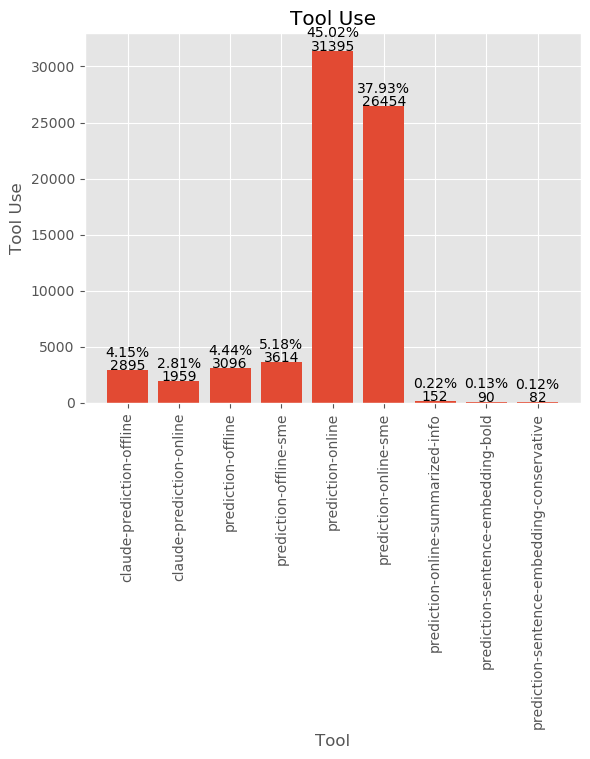

In [11]:
tool_use = dataset['tool'].groupby(dataset['tool']).count()

# plot tool use with data labels. use subplots plot % of tool use
fig, ax = plt.subplots()
ax.bar(tool_use.index, tool_use.values)
ax.set_xticklabels(tool_use.index, rotation=90)
ax.set_ylabel('Tool Use')
ax.set_xlabel('Tool')
ax.set_title('Tool Use')
for i, v in enumerate(tool_use.values):
    ax.text(i, v + 3, str(v), ha='center')
    # get percentage of tool use
    total = tool_use.values.sum()
    percent = v / total * 100
    ax.text(i, v + 1200, f'{percent:.2f}%', ha='center')

plt.show()


From above, there is currently a strong tendency to choose the prediction-online and prediction-online-sme tools.


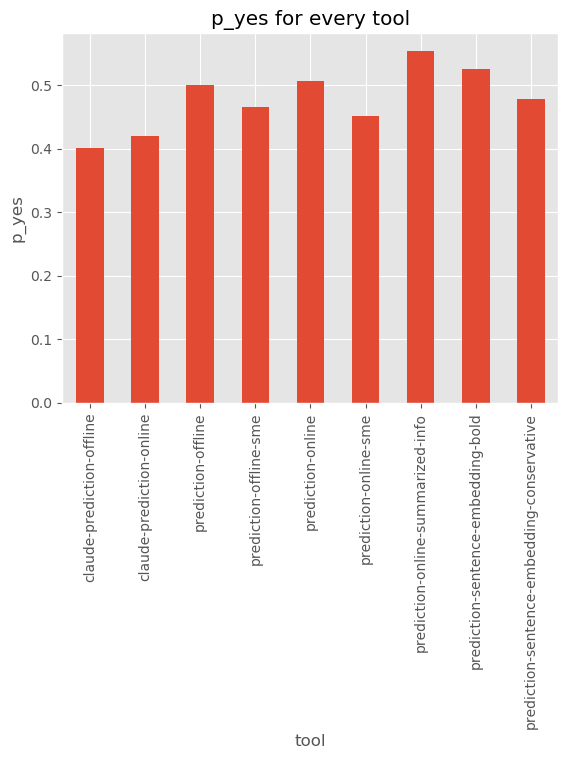

In [12]:
# plot p_yes for every tool
dataset.groupby('tool')['p_yes'].mean().plot(kind='bar', title='p_yes for every tool', ylabel='p_yes', xlabel='tool', rot=90)

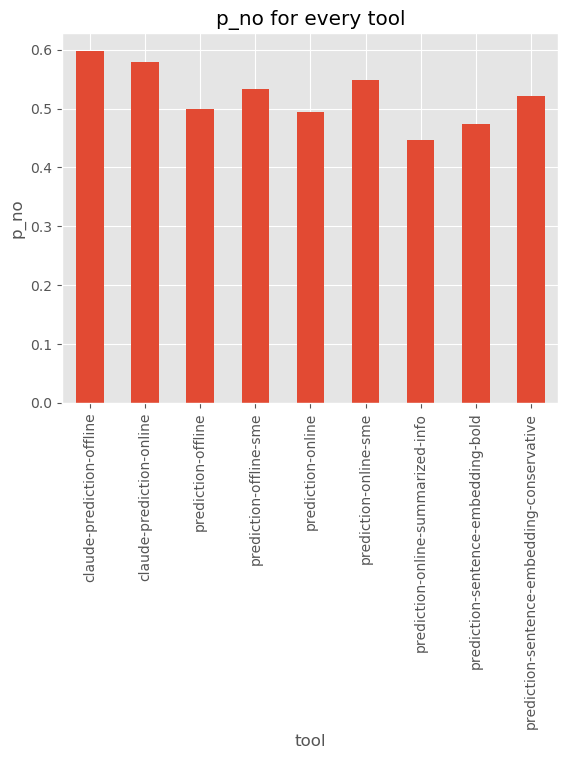

In [13]:
dataset.groupby('tool')['p_no'].mean().plot(kind='bar', title='p_no for every tool', ylabel='p_no', xlabel='tool', rot=90)

Text(0.5, 0, 'Tool')

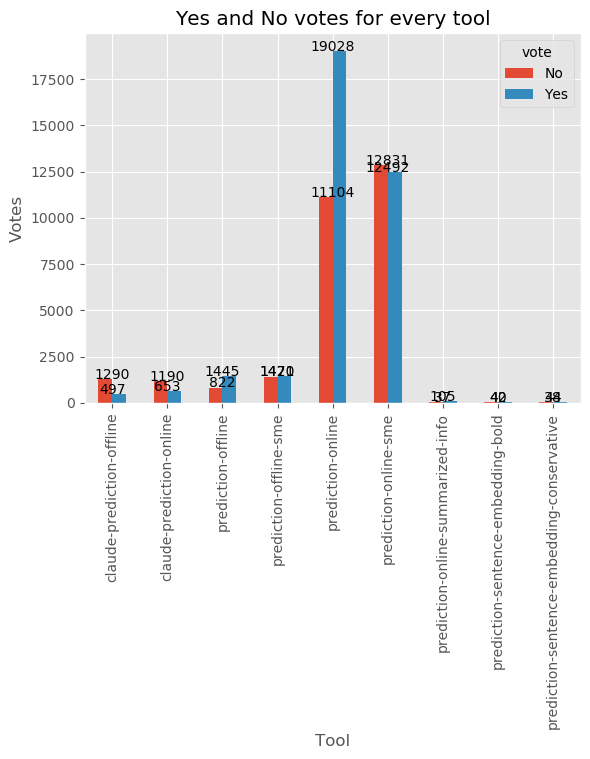

In [14]:
tool_vote = dataset.groupby(['tool', 'vote'])['vote'].count().unstack()

fig, ax = plt.subplots()
# plot Yes and No votes for every tool unstacked
ax = tool_vote.plot(kind='bar', stacked=False, ax=ax, rot=90, title='Yes and No votes for every tool')

# Data labels
for i, v in enumerate(tool_vote['Yes']):
    ax.text(i, v + 3, str(v), ha='center')

for i, v in enumerate(tool_vote['No']):
    ax.text(i, v + 20, str(v), ha='center')

ax.set_ylabel('Votes')
ax.set_xlabel('Tool')

From above, it seems like the prediction-online tool may have a large bias towards yes answers.

The Claude-based tools are the most accurate. However, they are not chosen nearly as much as the main two. 

### Check the percentage of wins vs confidence for all the tools

In [15]:
tools_group = dataset.groupby("tool")
tools_stats_per_conf = gen_stats(df=dataset, group=tools_group, col="confidence")
display(tools_stats_per_conf)

confidence_0.5                   \
                                                n_correct  n_pred accuracy   
tool                                                                         
claude-prediction-offline                           618.0  1053.0    58.69   
claude-prediction-online                            199.0   397.0    50.13   
prediction-offline                                    0.0     0.0      NaN   
prediction-offline-sme                                0.0     0.0      NaN   
prediction-online                                     0.0     0.0      NaN   
prediction-online-sme                                 1.0     3.0    33.33   
prediction-online-summarized-info                     0.0     0.0      NaN   
prediction-sentence-embedding-bold                    0.0     0.0      NaN   
prediction-sentence-embedding-conservative            0.0     0.0      NaN   

                                           confidence_0.6                  \
                                                n_correct n_pred accuracy   
tool                                                                        
claude-prediction-offline                            50.0  105.0    47.62   
claude-prediction-online                            250.0  435.0    57.47   
prediction-offline                                   19.0   38.0    50.00   
prediction-offline-sme                              111.0  189.0    58.73   
prediction-online                                   139.0  200.0    69.50   
prediction-online-sme                               320.0  655.0    48.85   
prediction-online-summarized-info                     1.0    2.0    50.00   
prediction-sentence-embedding-bold                    0.0    0.0      NaN   
prediction-sentence-embedding-conservative            0.0    0.0      NaN   

                                           confidence_0.7                   \
                                                n_correct  n_pred accuracy   
tool                                                                         
claude-prediction-offline                           182.0   422.0    43.13   
claude-prediction-online                            459.0   830.0    55.30   
prediction-offline                                  168.0   334.0    50.30   
prediction-offline-sme                              368.0   534.0    68.91   
prediction-online                                  2114.0  3193.0    66.21   
prediction-online-sme                              2606.0  5282.0    49.34   
prediction-online-summarized-info                     7.0    13.0    53.85   
prediction-sentence-embedding-bold                   22.0    36.0    61.11   
prediction-sentence-embedding-conservative            0.0     0.0      NaN   

                                           confidence_0.8                    \
                                                n_correct   n_pred accuracy   
tool                                                                          
claude-prediction-offline                            58.0    111.0    52.25   
claude-prediction-online                             64.0    169.0    37.87   
prediction-offline                                  712.0   1652.0    43.10   
prediction-offline-sme                              927.0   1954.0    47.44   
prediction-online                                 10790.0  23464.0    45.99   
prediction-online-sme                              9145.0  17674.0    51.74   
prediction-online-summarized-info                    47.0    103.0    45.63   
prediction-sentence-embedding-bold                   16.0     17.0    94.12   
prediction-sentence-embedding-conservative           18.0     35.0    51.43   

                                           confidence_0.9                   \
                                                n_correct  n_pred accuracy   
tool                                                                         
claude-prediction-offline                            78.0    

In [16]:
tools_stats_per_conf.loc[:, (slice(None), "accuracy")].sort_values(by=("total", "accuracy"), ascending=False)

,confidence_0.5,confidence_0.6,confidence_0.7,confidence_0.8,confidence_0.9,total
,accuracy,accuracy,accuracy,accuracy,accuracy,accuracy
tool,,,,,,
prediction-sentence-embedding-bold,NaN,NaN,61.11,94.12,93.10,79.27
claude-prediction-offline,58.69,47.62,43.13,52.25,81.25,55.18
claude-prediction-online,50.13,57.47,55.30,37.87,58.33,53.12
prediction-offline-sme,NaN,58.73,68.91,47.44,47.20,52.13
prediction-online-sme,33.33,48.85,49.34,51.74,57.64,51.56
prediction-sentence-embedding-conservative,NaN,NaN,NaN,51.43,48.94,50.00
prediction-online,NaN,69.50,66.21,45.99,52.37,48.98
prediction-online-summarized-info,NaN,50.00,53.85,45.63,58.33,48.59


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

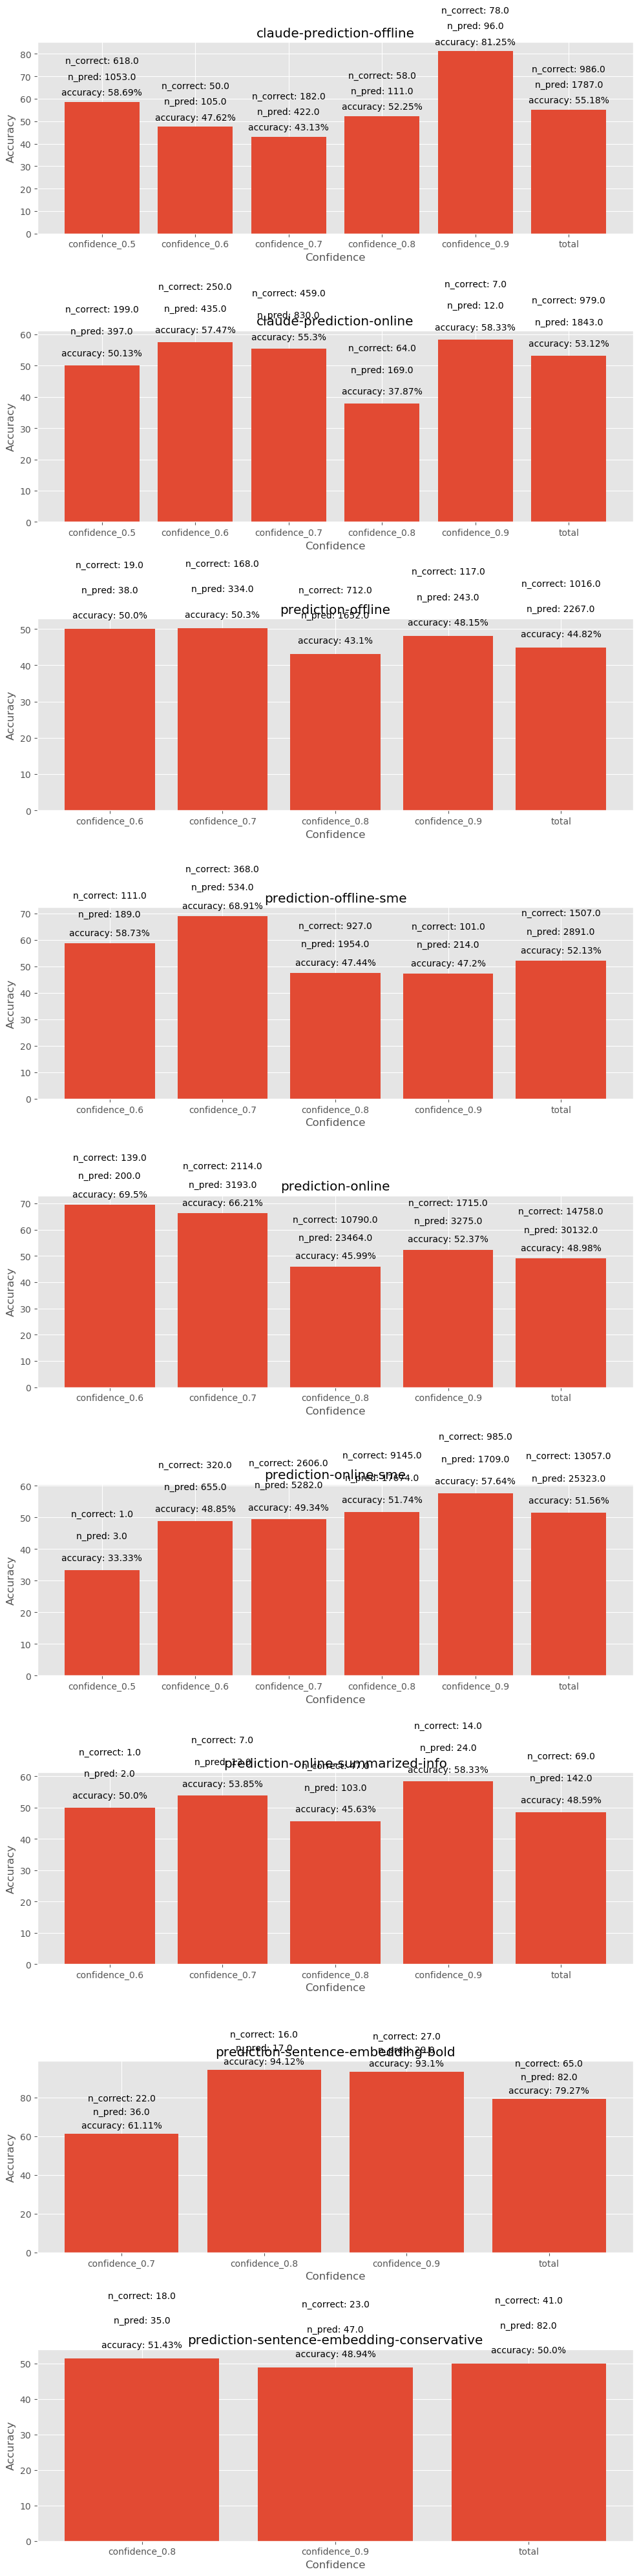

In [17]:
tools = tools_stats_per_conf.index

fig, axes = plt.subplots(nrows=len(tools), ncols=1, figsize=(10, 40))

for i, tool in enumerate(tools):
    ax = axes[i]
    tool_stats = tools_stats_per_conf.loc[tool].unstack(level=0).loc["accuracy"]
    ax.bar(tool_stats.index, tool_stats.values)
    ax.set_title(tool)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Confidence")

    for j, v in enumerate(tool_stats.values):

        # add n_pred and n_correct
        n_pred = tools_stats_per_conf.loc[tool].unstack(level=0).loc["n_pred"]
        n_correct = tools_stats_per_conf.loc[tool].unstack(level=0).loc["n_correct"]
        ax.text(j, v + 10, f"n_pred: {n_pred[j]}", ha='center')
        ax.text(j, v + 17, f"n_correct: {n_correct[j]}", ha='center')
        ax.text(j, v + 3, f"accuracy: {round(v, 2)}%", ha='center')

plt.tight_layout()

The above shows that for each tool, higher confidences do not really bring higher accuracy. 

In [18]:
vote_analysis = dataset['vote'].value_counts()
print(vote_analysis)

Yes    35770
No     28779
Name: vote, dtype: Int64


In [19]:
# value counts above 50
sel = list(dataset['id'].value_counts()[dataset['id'].value_counts() > 50].index)
sel_dataset = dataset[dataset['id'].isin(sel)]
sel_dataset['id'].nunique()

476

Text(0.5, 1.0, 'Number of Tools per ID. Total IDs: 476')

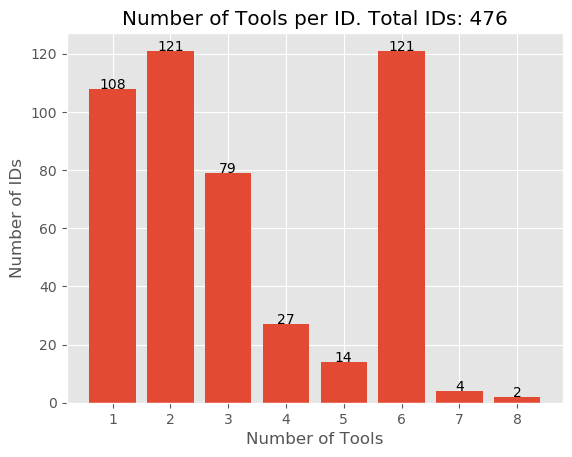

In [20]:
tools_per_id = sel_dataset.groupby('id')['tool'].nunique()

tools_per_id = tools_per_id.value_counts().sort_index()


fig, ax = plt.subplots()
ax.bar(tools_per_id.index, tools_per_id.values)
ax.set_ylabel('Number of IDs')
ax.set_xlabel('Number of Tools')

for i, v in enumerate(tools_per_id.values):
    ax.text(i+1, v, str(v), ha='center')

plt.title('Number of Tools per ID. Total IDs: ' + str(sel_dataset['id'].nunique()))

The above chart shows for each id/title what is the diversity of the tools used. Mostly, 1 or 2 is used.


In [21]:
dataset[['id', 'currentAnswer']].drop_duplicates()['currentAnswer'].value_counts()

No     1021
Yes     599
no        1
IND       1
Name: currentAnswer, dtype: Int64

In [22]:
vote_counts_per_id = dataset.groupby('id')['vote'].value_counts().unstack(fill_value=0)
vote_counts_per_id['yes_no_ratio'] = vote_counts_per_id['Yes'] / (vote_counts_per_id['No'] +1)

In [23]:
vote_counts_per_id['yes_perc'] = vote_counts_per_id['Yes']/(vote_counts_per_id['Yes'] + vote_counts_per_id['No'])
vote_counts_per_id['no_perc'] = vote_counts_per_id['No']/(vote_counts_per_id['Yes'] + vote_counts_per_id['No'])

In [24]:
vote_counts_per_id['yes_perc'].min(), vote_counts_per_id['yes_perc'].max(), vote_counts_per_id['yes_perc'].mean(), vote_counts_per_id['yes_perc'].median()

(0.0, 1.0, 0.5957927347931947, 0.6666666666666666)

In [25]:
vote_counts_per_id['no_perc'].min(), vote_counts_per_id['no_perc'].max(), vote_counts_per_id['no_perc'].mean(), vote_counts_per_id['no_perc'].median()

(0.0, 1.0, 0.4042072652068053, 0.3333333333333333)

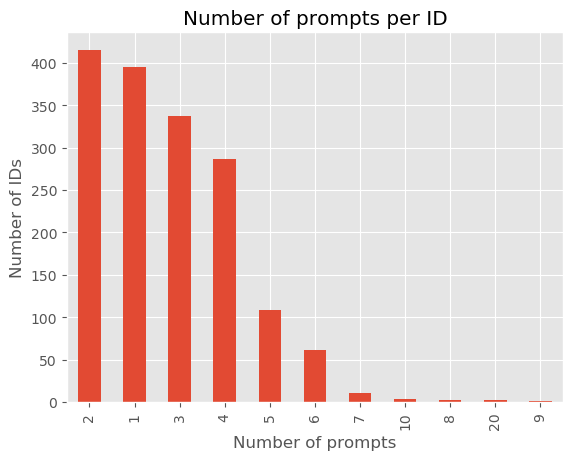

In [26]:
dataset.groupby('id')['prompt_request'].nunique().value_counts().plot(kind='bar', title='Number of prompts per ID', ylabel='Number of IDs', xlabel='Number of prompts')

The above chart shows for each id/title what is the diversity of the prompt coming from the trader. It seems that the default prompt is rarely changed.